# CESM-LE analysis
### Looks at snow pack changes over time, globally
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily SNOWDP, soil temperature & runoff
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.17.0'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.02.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
ncores = 10
nmem = str(int(400 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=9, maximum_jobs=9)  # change to 9 w/ 50 ens members
client = Client(cluster)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43050 instead
  http_address["port"], self.http_server.port


In [6]:
#cluster.close()

In [7]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel ########`

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [23]:
#client.restart()

In [24]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [25]:
def file_dict(model,mem,field,hist=True,freq='monthly'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        lnd     = '/lnd/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            tape    = '.h5.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+runtype+mm+lnd+freq
        #find all the relevant files
        files = glob.glob(thisdir+'*'+tape+field+'*')
        
    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [26]:
def get_file(model,mem,field,year,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [27]:
def all_files(model,ens,field,firstyear,lastyear,freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [28]:
def get_data(model,ens,fields,firstyear,lastyear,freq,chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                    concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [29]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

--------------------
## Start editing here:
### Actually read in data

In [30]:
%%time
model = 'CESM2'
ens = 10+np.arange(20)
# maybe use SWE instead of snow depth?
fields = ['SNOWDP','QRUNOFF']
firstyear = 1850
lastyear  = 2100
freq      = 'daily'
ds = get_data(model,ens,fields,firstyear,lastyear,freq).persist()
ds.nbytes/1e9 #GB

CPU times: user 41.8 s, sys: 706 ms, total: 42.5 s
Wall time: 44.2 s


810.56223824

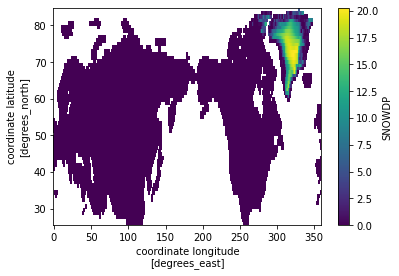

In [31]:
# we'll just look at 23-80 N for convenience
ds = ds.sel(lat=slice(25,85))

# mask out regions with very little snow or that never melt out
minSnow = 0.1
ds = ds.where(ds.SNOWDP.max('time')>minSnow) 
NotAllSnow = ds.SNOWDP.isel(time=slice(-3650,None)).min(dim=['ens','time'])
NotAllSnow.plot()
ds = ds.where(NotAllSnow==0) 

### Calculate running mean for QRUNOFF to smooth results
- convert units to mm/d

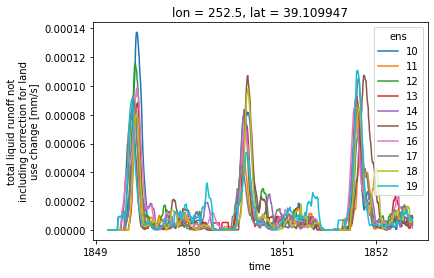

In [32]:
temp = ds.QRUNOFF.rolling(time=21, center=True).mean()
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

temp.sel(lat = plat, lon = plon, method='nearest') \
  .isel(time=slice(0,1000), ens=slice(0,10)) \
  .plot(x='time',hue='ens');

In [33]:
ds['QRUNOFF']

,Array,Chunk
Bytes,132.98 GB,72.58 MB
Shape,"(20, 91616, 63, 288)","(1, 1000, 63, 288)"
Count,17167 Tasks,2020 Chunks
Type,float32,numpy.ndarray


In [34]:
%%time 
# TODO, changing time chunks may make this more efficient?
s2d = 3600 * 24
ds['QRUNOFF'] = ds.QRUNOFF.chunk({"time": 100}).rolling(time=21, center=True).mean()
ds['QRUNOFF'] = (ds['QRUNOFF'] *s2d).persist()
ds['QRUNOFF'].attrs['units'] = 'mm/d'

# Get chunks for Qrunnoff back to 'normal'
ds['QRUNOFF'] = ds.QRUNOFF.chunk({"time": 1000})

CPU times: user 1min 43s, sys: 1.3 s, total: 1min 44s
Wall time: 1min 44s


,Array,Chunk
Bytes,132.98 GB,72.58 MB
Shape,"(20, 91616, 63, 288)","(1, 1000, 63, 288)"
Count,11107 Tasks,2020 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,265.96 GB,14.52 MB
Shape,"(20, 91616, 63, 288)","(1, 100, 63, 288)"
Count,18340 Tasks,18340 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [39]:
ds['QRUNOFF'] = ds.QRUNOFF.chunk({"time": 1000})

----------------
### Characterize snow dynamics & snow free period
- Day of year with max runoff, max daily runoff, and total annual runoff
- Day of year with snow off, snow on, snow free period & max snow depth

In [40]:
noSNOW = ds.time.dt.dayofyear.where(ds.SNOWDP<=0).transpose('ens','time','lat','lon')
ann_coords = ds.SNOWDP.resample(time='AS').max('time').coords
dsANN = xr.Dataset(coords=ann_coords)
dsANN['MaxSnow'] = ds.SNOWDP.resample(time='AS').max('time')
dsANN['MaxQrun'] = ds.QRUNOFF.resample(time='AS').max('time')
dsANN['TotQrun'] = ds.QRUNOFF.resample(time='AS').sum('time')
dsANN['MaxQrunDate'] = ds.QRUNOFF.fillna(0).groupby('time.year') \
    .apply(lambda c: c.argmax(dim="time",skipna=True))

# min / max day of year w/o snow
## used to calculated sno
dsANN['LastSnow'] = noSNOW.where(noSNOW>30).resample(time='AS') \
    .min('time',skipna=True).astype('int') 
dsANN['FirstSnow'] = noSNOW.where(noSNOW>180).resample(time='AS') \
    .max('time',skipna=True).astype('int') 
dsANN['SnowFree'] = (dsANN.FirstSnow - dsANN.LastSnow).astype('int') 

# should check this is snow free between dates?
sno_vars = ['MaxSnow','LastSnow','FirstSnow',
            'SnowFree','MaxQrun','MaxQrunDate','TotQrun']
dsANN.MaxSnow.attrs['long_name'] = 'max annual snow depth'
dsANN.MaxQrun.attrs['long_name'] = 'max runoff'
dsANN.TotQrun.attrs['long_name'] = 'total runoff'
dsANN.TotQrun.attrs['units'] = 'mm y^-1'
dsANN.MaxQrunDate.attrs['long_name'] = 'date of max runoff'
dsANN.LastSnow.attrs['long_name'] = 'first snow free day'
dsANN.FirstSnow.attrs['long_name'] = 'last snow free day'
dsANN.SnowFree.attrs['long_name'] = 'number of snow free days'

dsANN.coords['time'] = dsANN['year']
dsANN = dsANN.swap_dims({"year": "time"})

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [41]:
dsANN

,Array,Chunk
Bytes,364.33 MB,72.58 kB
Shape,"(20, 251, 63, 288)","(1, 1, 63, 288)"
Count,39247 Tasks,5020 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,728.66 MB,145.15 kB
Shape,"(20, 251, 63, 288)","(1, 1, 63, 288)"
Count,48920 Tasks,5020 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


#### Mask out regions that initially have 
   - less than 10 cm snow depth & 
   - more than 275 snow free days (min 3 months snow coverage)
   - continually snow covered

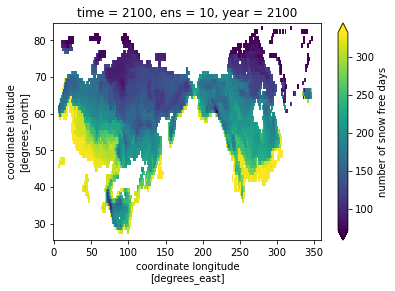

In [42]:
dsANN = dsANN.where(dsANN.MaxSnow.isel(time=slice(0,30)).mean('time')>minSnow)

minSnowFree = 275 
snowMask = dsANN.SnowFree.isel(time=slice(0,30)).mean(dim=['time','ens'])
dsANN = dsANN.where(snowMask<minSnowFree)

# again, mask out grids that never melt
dsANN = dsANN.where(NotAllSnow==0).compute()
dsANN.SnowFree.isel(ens=0,time=-1).plot(robust=True) ;

In [43]:
%%time
# ensemble mean of annual data
ds_ensMean = dsANN.mean('ens',skipna=True).compute()
ds_ensStd = dsANN.std('ens',skipna=True).compute()

CPU times: user 5.95 s, sys: 1.4 s, total: 7.35 s
Wall time: 6.52 s


### Length of snow free season & change over time

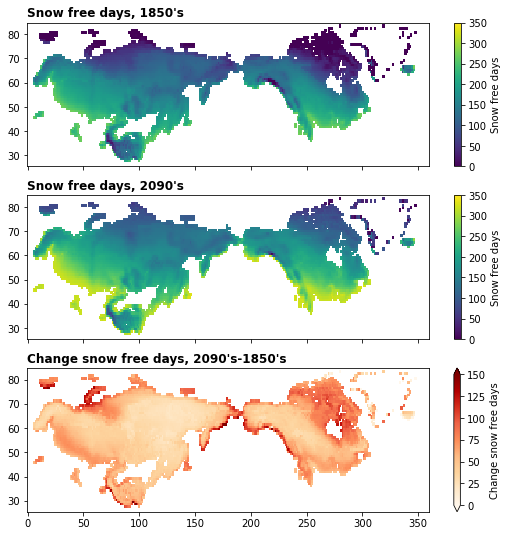

In [54]:
# Number of snow free days
plotVar = 'SnowFree'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title("Snow free days, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=350, vmin=0,
    cbar_kwargs={'label': 'Snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title("Snow free days, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=350, vmin=0,
    cbar_kwargs={'label': 'Snow free days'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change snow free days, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensMean[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=150,vmin=0, 
    cbar_kwargs={'label': 'Change snow free days'},cmap='OrRd') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

### max runoff day 

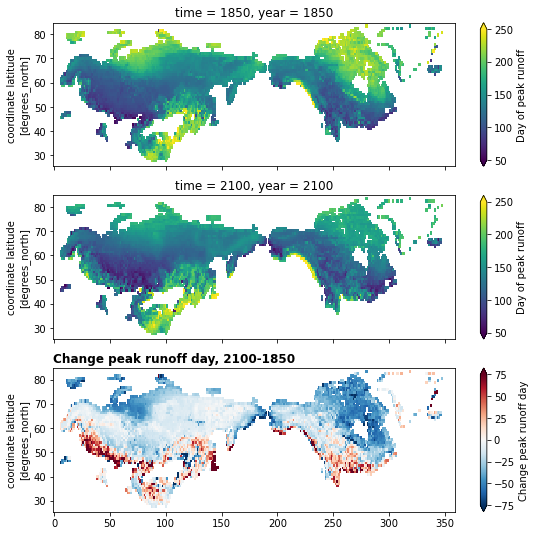

In [55]:
# Day of max runoff
plotVar = 'MaxQrunDate'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')

ds_ensMean[plotVar].isel(time=0).plot(
    ax=ax1, vmax=250, vmin=50,cbar_kwargs={'label': 'Day of peak runoff'}) ;
ax1.set_xlabel('')

ds_ensMean[plotVar].isel(time=-1).plot(
    ax=ax2, vmax=250, vmin=50,cbar_kwargs={'label': 'Day of peak runoff'}) ;
ax2.set_xlabel('')

# Change in peak runoff 2100 - 1901
ax3.set_title('Change peak runoff day, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(ds_ensMean[plotVar].isel(time=-1) - ds_ensMean[plotVar].isel(time= 0)).plot(ax=ax3,
    vmax=-75,vmin=75, cbar_kwargs={'label': 'Change peak runoff day'},cmap='RdBu_r') 
ax3.set_xlabel('') ; 

_Do regions with later runoff days become rain / warm season precip dominanted?_

### Zoom into regional changes 

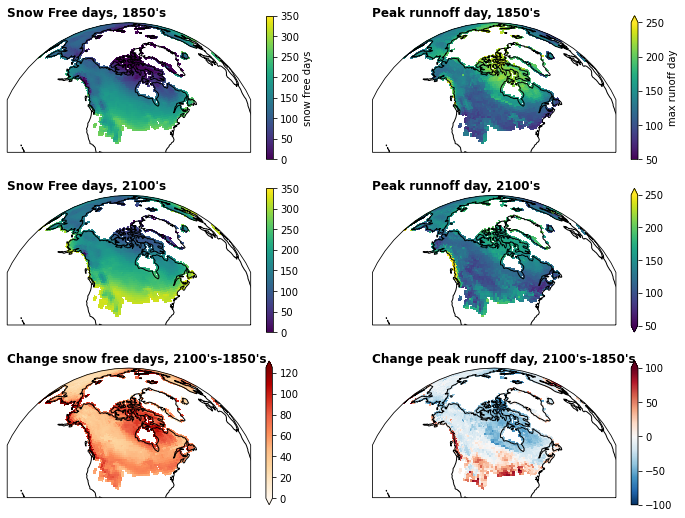

In [56]:
# Number of snow free days
plotVar = ['SnowFree','MaxQrunDate']
#lat,lon,region,ortho = [25,80], [0,360], 'Europe', [80,30]
lat,lon,region,ortho = [35,85], [0,360], 'W. NA',[-100,30]
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(
    3,2, figsize=(12, 9),sharey='row',sharex='col',
    subplot_kw=dict(projection=ccrs.Orthographic(ortho[0], ortho[1])) )

# free days 1901 
ax1.set_title("Snow Free days, 1850's",loc='left', fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.coastlines()  # cartopy function

ax2.set_title("Peak runnoff day, 1850's",loc='left', fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.coastlines()  # cartopy function

# free days 2100 
ax3.set_title("Snow Free days, 2100's",loc='left', fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.coastlines()  # cartopy function

ax4.set_title("Peak runnoff day, 2100's",loc='left', fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.coastlines()  # cartopy function

# Change  2100 - 1901
ax5.set_title("Change snow free days, 2100's-1850's",loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[0]].isel(time=slice(  0,10  )).mean('time')).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.coastlines()  # cartopy function

ax6.set_title("Change peak runoff day, 2100's-1850's",loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[1]].isel(time=slice(  0,  10)).mean('time')).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=100,vmin=-100, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  
ax6.coastlines() ;  # cartopy function

### Start by looking at a single gridcell

In [57]:
WaterYear = False   # logical for converting time to water year, used below

plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

dsPT = ds.sel(lat = plat, lon = plon, method='nearest')
dsPTANN = dsANN.sel(lat = plat, lon = plon, method='nearest')

CPU times: user 13 s, sys: 663 ms, total: 13.7 s
Wall time: 14.7 s


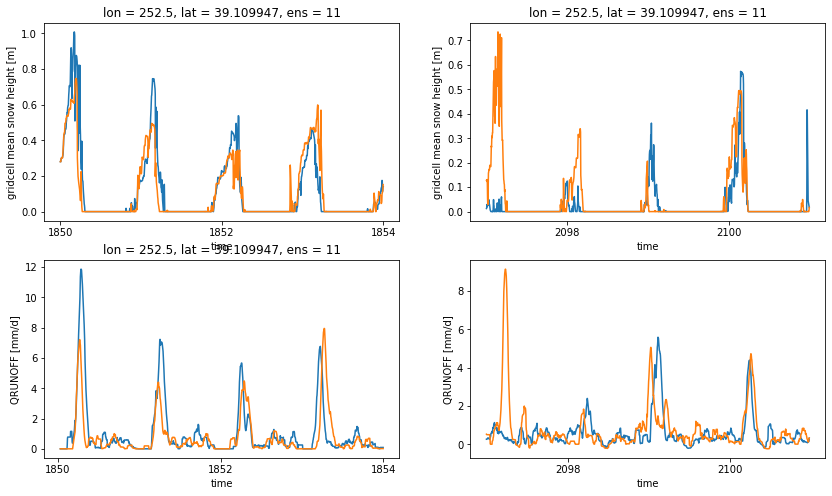

In [58]:
%%time 
# look at first ~5 years of data 

plt.figure(figsize=[14,8])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(2,2,p)
    dsPT[fields[i]].isel(time=slice(0,(365*4)), ens=0).plot(x='time') ;
    dsPT[fields[i]].isel(time=slice(0,(365*4)), ens=1).plot(x='time') ;

    p = p+1
    plt.subplot(2,2,p)
    dsPT[fields[i]].isel(time=slice((-365*4),-1), ens=0).plot(x='time') ;
    dsPT[fields[i]].isel(time=slice((-365*4),-1), ens=1).plot(x='time') ;
    if i >0: 
        plt.title(" ") ;

#### Look at changes in snow depth & vernal window, single site

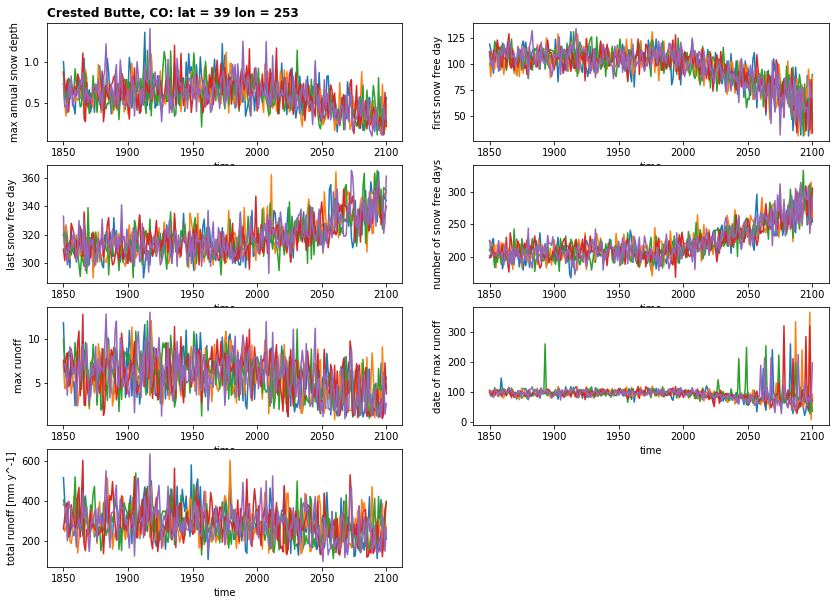

In [59]:
# Plotting daily data takes forever... may skip this?
# look at raw data
plt.figure(figsize=[14,10])
for i in range(len(sno_vars)):
    plt.subplot(4,2,(i+1))
    dsPTANN[sno_vars[i]].isel(ens=slice(0,5)).plot(hue='ens',add_legend=False)  
    plt.title(" ") ;
    if i == 0: plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
    

<Figure size 1008x792 with 0 Axes>

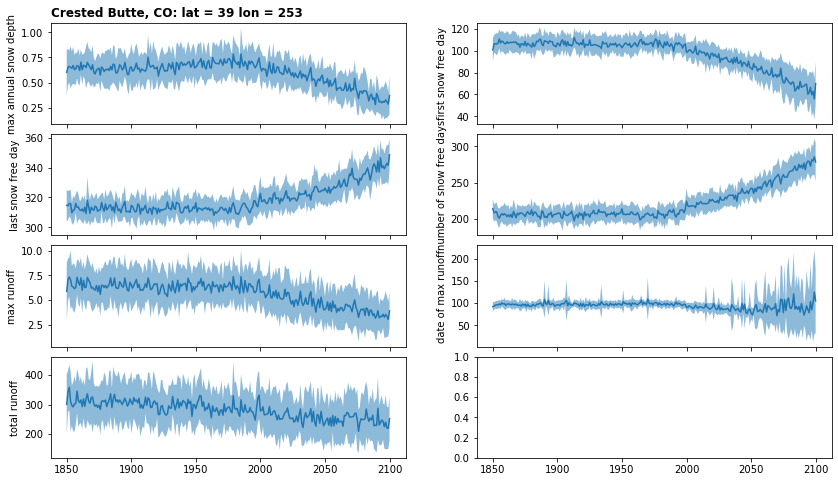

In [60]:
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
        
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(dsANN[sno_vars[v]].attrs['long_name']) ;
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') 
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0

Work computing time of emergce for chagnes in the 'vernal window', 
- below dive into changes in snow and soil temperature over time

## Flavio defined ToE as time when 10 year running mean > baseline
#### Here we'll take: 
- 30 year baseline (1850-1880)
- 10 year running mean

In [61]:
%%time 
# ensemble mean and std over first 30 years
dsBase    = dsANN.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = dsANN.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
#print(dsBase)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: Runt

CPU times: user 1.1 s, sys: 249 ms, total: 1.35 s
Wall time: 1.21 s


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### TODO
- do you take ensemble mean over years, and then 10 year rolling mean?
- here take rolling mean of each ensemble, then take ensemble statistics.

In [62]:
%%time 
#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = dsANN.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()

CPU times: user 19.2 s, sys: 16.1 s, total: 35.4 s
Wall time: 38.4 s


#### Plot: 
* ensemble mean & standard deviation
* rolling mean & rolling std
* base mean and std (all ensembles over first 20 years)

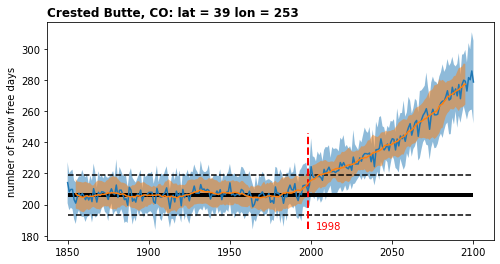

In [63]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

plt.figure(figsize=[8,4])
x = ds_ensMean.time
y = ds_ensMean['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel(dsANN['SnowFree'].attrs['long_name']) ;

x = roll_ensMean.time
y = roll_ensMean.SnowFree.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.SnowFree.sel(lat = plat, lon = plon, method='nearest')
plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

plt.hlines(dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest'), 1850, 2100, colors='k',lw=4) ;
plt.hlines((dsBase.SnowFree + dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') ;
plt.hlines((dsBase.SnowFree - dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*1.2,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

#### Test code for all variables

<Figure size 1008x792 with 0 Axes>

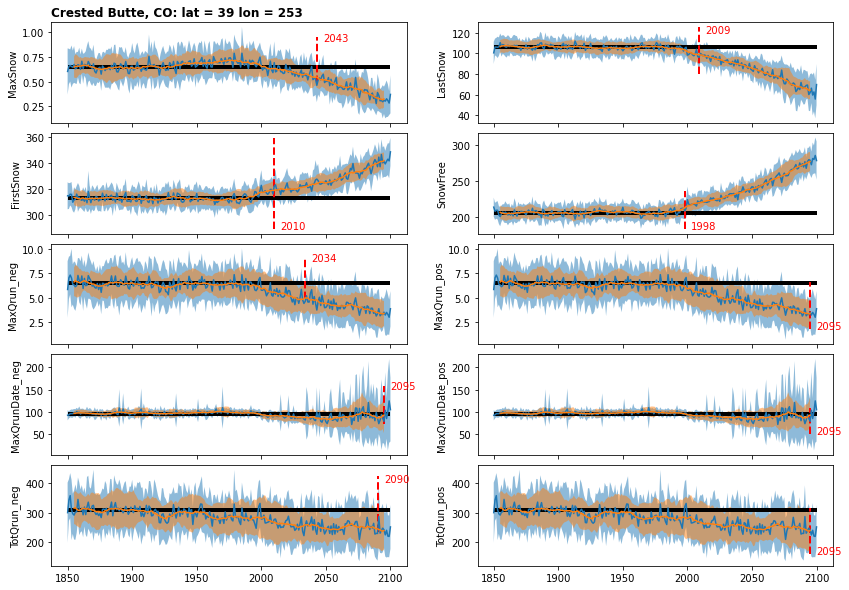

In [64]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 

in_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree',
           'MaxQrun','MaxQrun',
           'MaxQrunDate','MaxQrunDate',
           'TotQrun','TotQrun']
sno_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree',
            'MaxQrun_neg','MaxQrun_pos',
            'MaxQrunDate_neg','MaxQrunDate_pos',
            'TotQrun_neg','TotQrun_pos']
sno_trend = ['neg','neg',
             'pos','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos']
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(5,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,10))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')

    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(sno_vars[v]) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase[in_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1850, 2100, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)

    if sno_trend[v] == 'pos': 
        axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.15,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
    else: 
        axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.max()*1.05, ToE.values,color='r')
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0 ;

#### Time of emergence globally

<xarray.DataArray 'time' ()>
array(1998)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11


<xarray.DataArray 'time' ()>
array(2100)

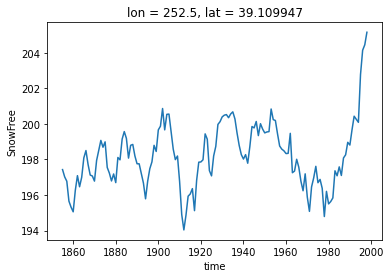

In [65]:
import cartopy.crs as ccrs
# find ToE for Snow free days when roll mean - 2 std < baseline
test = roll_ensMean.SnowFree - 2*roll_ensStd.SnowFree
test = test.where(test<dsBase.SnowFree)
GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
print(GOI.time.max())#isel(time=-1))
GOI.plot()

test.time.max()#.groupby()['time'].max()
#test.time.dropna('time').plot()
#test = test.idxmax(dim='time')
#test.where(test>1850).sel(lon=slice(5,44),lat=slice(50,77)).plot(    
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={
    #    "projection": ccrs.LambertConformal(
    #        central_longitude=0, central_latitude=60
    #    )
    #},
#    robust=True) ;
#print(test)

<xarray.DataArray 'time' (lat: 63, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35


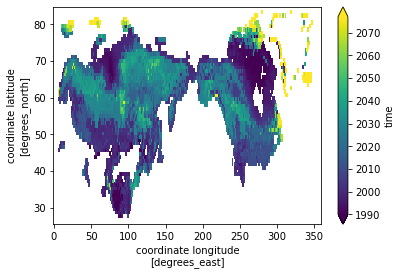

In [66]:
ToE_coords = test.coords
ToE = xr.Dataset(coords=ToE_coords)

for v in range(len(sno_vars)):
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[in_vars[v]] - 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp<dsBase[in_vars[v]])
    else:
        temp = roll_ensMean[in_vars[v]] + 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp>dsBase[in_vars[v]])
    
    if v == 3:
        print(temp.max(dim='time'))
        temp.max(dim='time').plot(robust=True)
    ToE[sno_vars[v]] = temp.max(dim='time')

    ToE = ToE.where(ToE>1850)

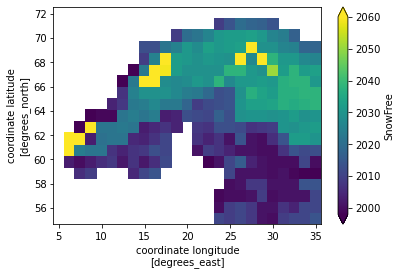

In [67]:
ToE.SnowFree.sel(lon=slice(5,35),lat=slice(55,73)).plot(robust=True) ;

In [68]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,pad=0.05, fraction = 0.1, orientation='horizontal')

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


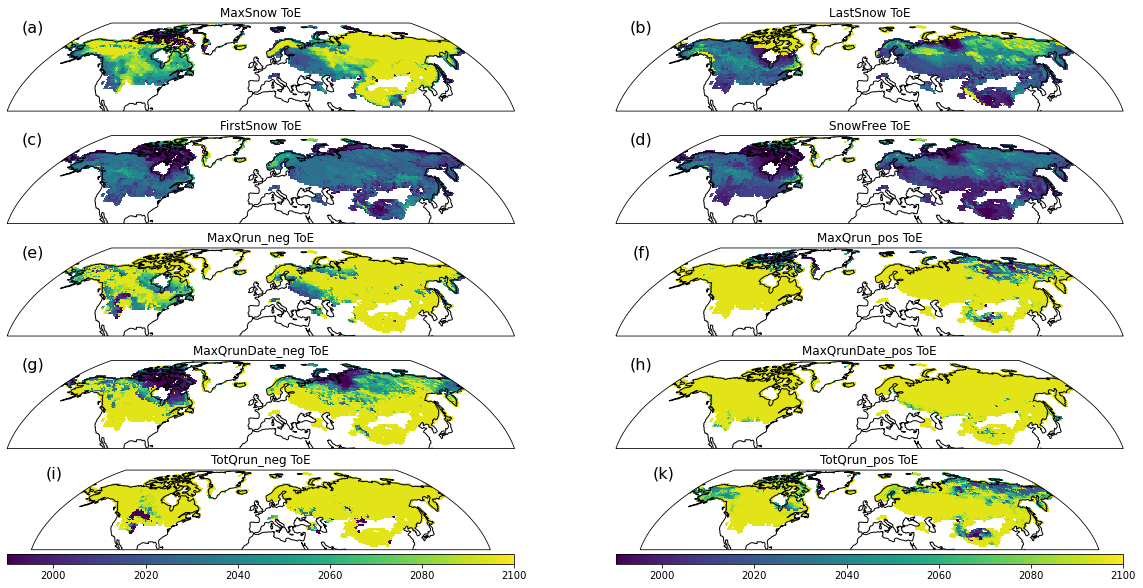

In [69]:
# Now call the map_function
#---------------------
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(k)','(l)','(m)','(n)']  

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,10), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,0,0,0,0,0,1,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ToE[sno_vars[i]]
    map_function(da, panel=panel[i], ax=ax, title=sno_vars[i]+' ToE', 
                 vmin=1990, vmax=2100, cb=cb[i])

    i = i+1

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5);
#plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3c_GPP_DTcorr.eps')


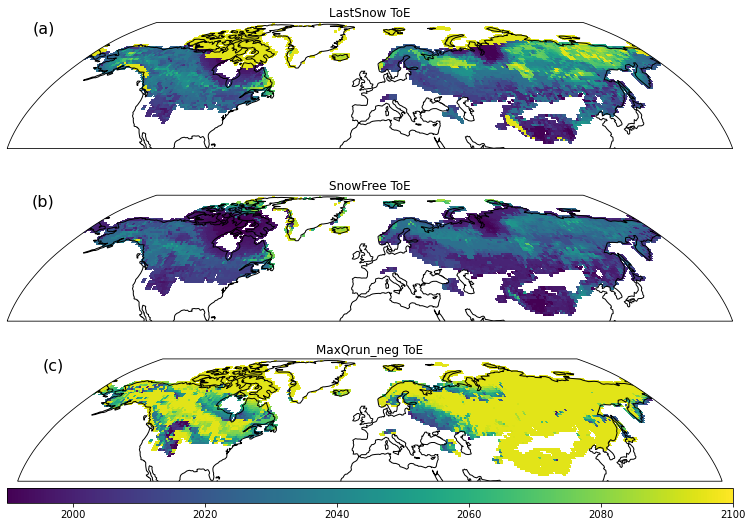

In [70]:
pltVars = ['LastSnow','SnowFree','MaxQrun_neg']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13,9), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1



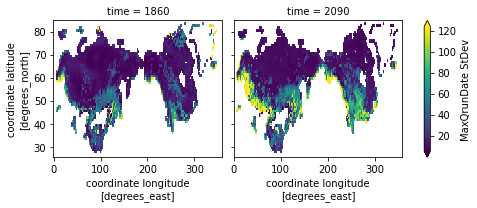

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/scheduler.py", line 5487, in retire_workers
    lock=False,
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/scheduler.py", line 5231, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - Exception while handling op retire_workers
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/core.py", line 500, in handle_comm
    result = await result
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/scheduler.py", line 5487, in retire_workers
    lock=False,
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/py

In [71]:
plotVar = 'MaxQrunDate'
ds_ensStd[plotVar].isel(time=[10,-11]).plot(y='lat',x='lon',col="time",
                                            col_wrap=2, robust=True,
                                            cbar_kwargs={"label": plotVar+" StDev",
                                            "pad": 0.05 }  # passed to plt.colorbar
                                           ) ;

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1